In [1]:
#Goal is make a 12 multi-panel plots of the climatology. 
#Since assignment was looking at the 500mb geopotential height on a specific day
#in Jan 18, 1985. Want to plot the climatology for the 6 days prior and 6 days after 
#Jan 13, 1985-Jan 24, 1985

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

file = "/scratch/kbarrag/clim680_dataset/mean/erai.z500.day.mean.1979-2019.nc"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [2]:
#First to grab all the january's from the list of years

# Use groupby to organize the data into months
# then use .groups to get the indexes for each month
ds_month=ds.groupby('time.month').groups
ds_month

# Get the time index to all the Januarys 
ds_jan=ds_month[1]


# Extracted january months by selecting the right indexes
ds_all_jan=ds.isel(time=ds_jan)

ds_all_jan


<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 1271)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-01-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [3]:
#grouping by day and finding the mean for the data to find the climatology
ds_climo = ds_all_jan.groupby('time.day').mean(dim='time')
ds_climo

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, day: 31)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Data variables:
    z500     (day, lat, lon) float32 5.752e+04 5.752e+04 ... 4.988e+04 4.988e+04

In [4]:
#Now to to again select/slice the specific days we nee
ds_jan_dates= ds_climo.isel(day=slice(12,24))
ds_jan_dates

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, day: 12)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * day      (day) int64 13 14 15 16 17 18 19 20 21 22 23 24
Data variables:
    z500     (day, lat, lon) float32 5.752e+04 5.752e+04 ... 4.974e+04 4.974e+04

Text(0.5, 0.98, 'Mean 500mb Geopotential Height for Jan 13-24 from 1979-2019')

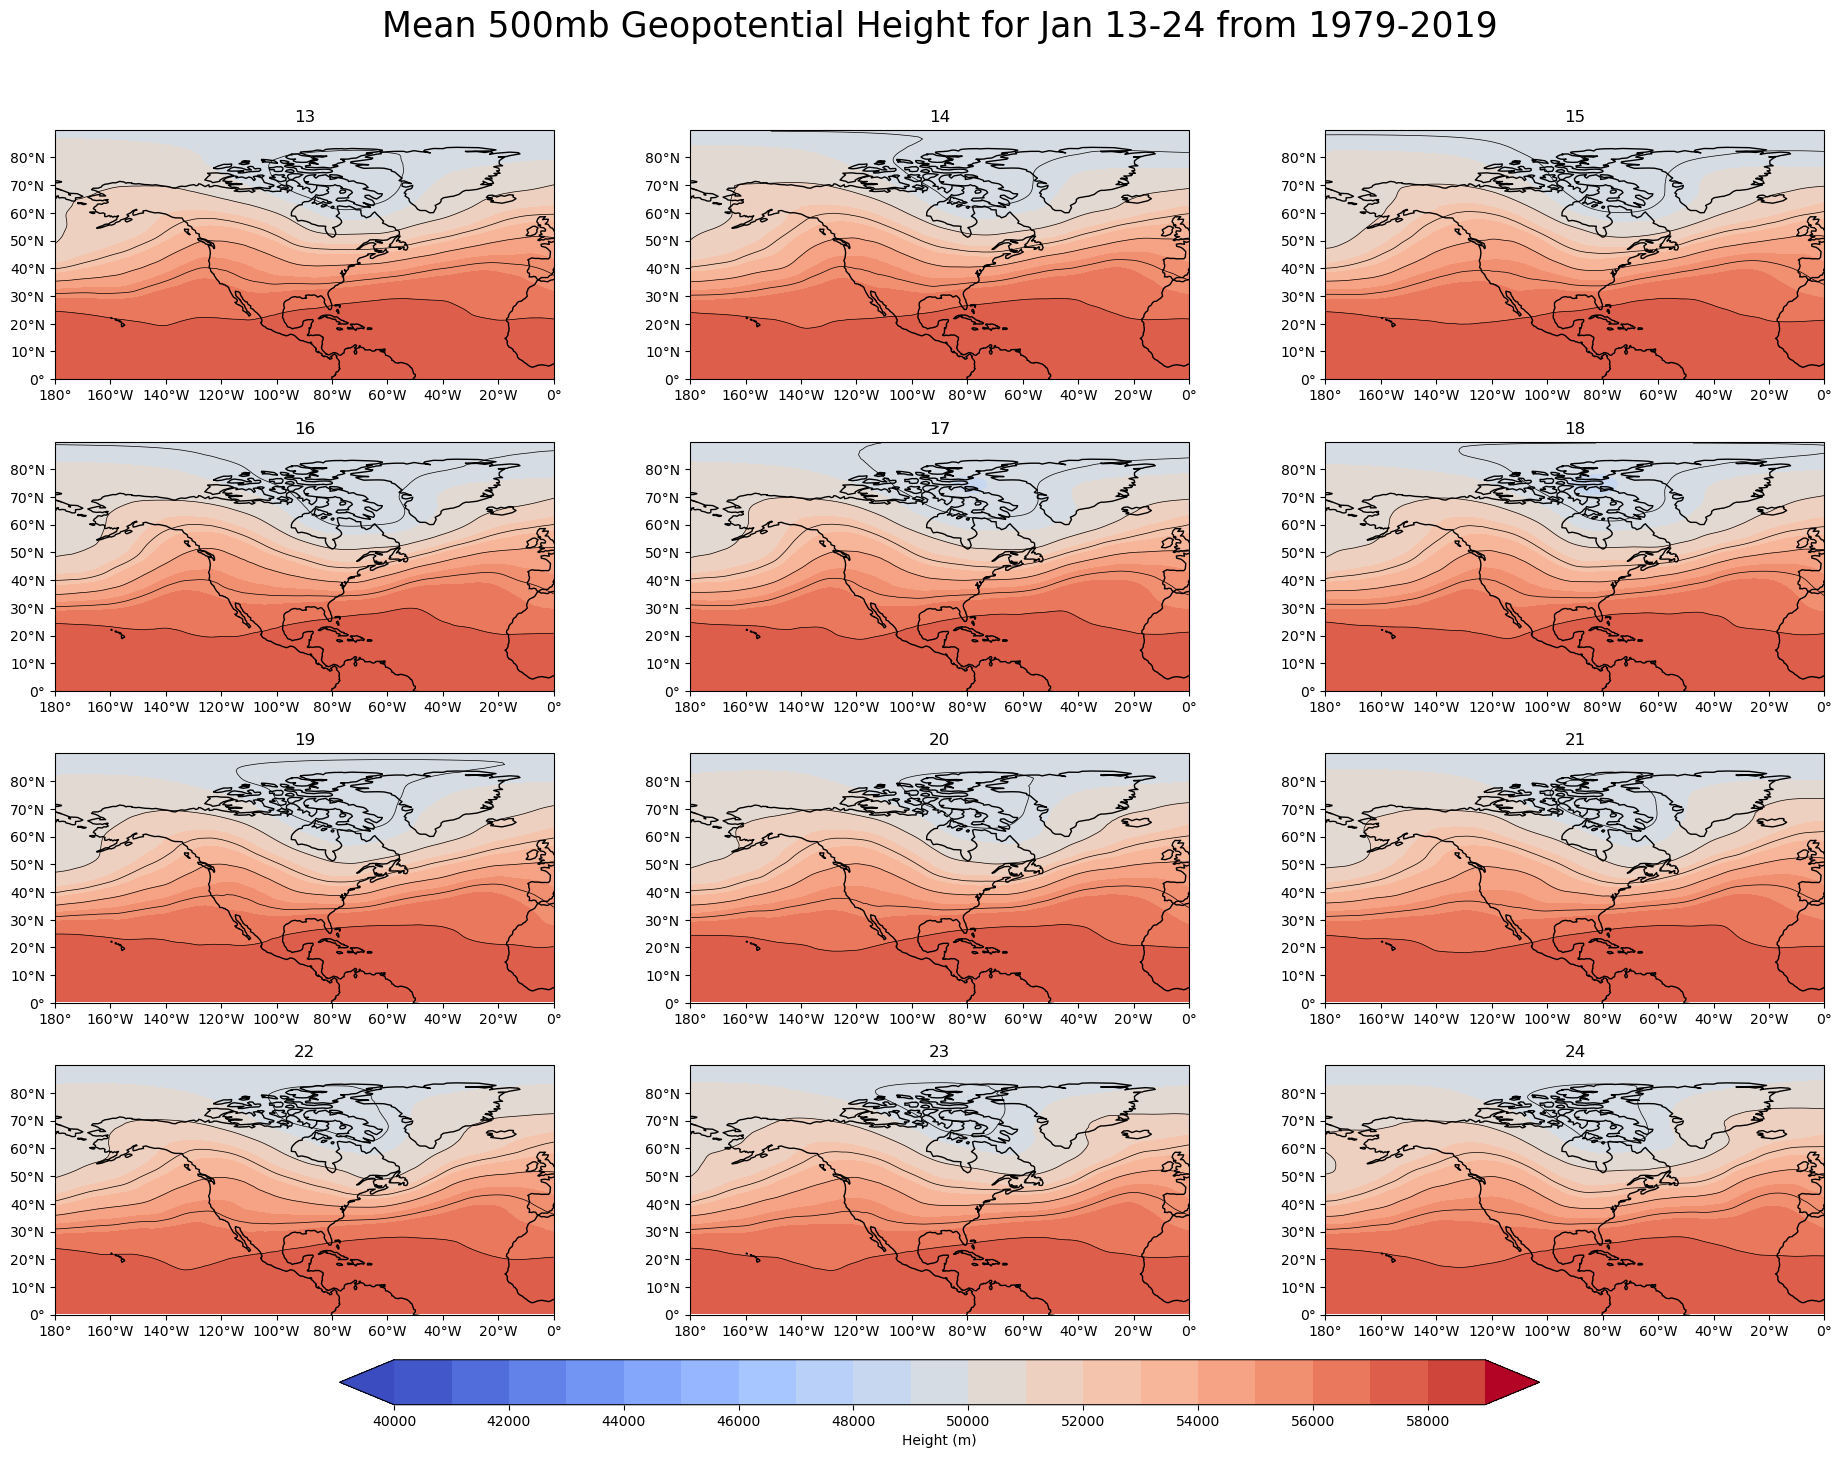

In [5]:
#Now to combine with a 'for' loop to create the plot
                
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= ds_jan_dates['z500'].min()
max_z500= ds_jan_dates['z500'].max()


clevs = np.arange(40000,60000,1000)
levels = np.arange(min_z500,max_z500,600)
divnorm = colors.CenteredNorm(vcenter=50000)

axs=axs.flatten()

#Loop over all of the day and plot
for i, day in enumerate(ds_jan_dates['day']):

    # Select the day
    data=ds_jan_dates['z500'].sel(day=day)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=ds_jan_dates['lon'])

    # Contour plot
    cs=axs[i].contour(lons,ds_jan_dates['lat'],data,
                      transform = ccrs.PlateCarree(),
                      colors='black',extend='both', linewidths= .5)
      
    #Color filled Contour Plot
    cs1=axs[i].contourf(lons, 
                ds_jan_dates['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "coolwarm",
                transform = ccrs.PlateCarree(),
                extend='both')
    
 

    # Title each subplot with the name of the model
    axs[i].set_title(day.values)
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Height (m)')



plt.suptitle('Mean 500mb Geopotential Height for Jan 13-24 from 1979-2019', fontsize=25 )



In [6]:
#issue: Center of normalize not displaying correct. Colors ugly

Text(0.5, 0.98, 'Mean 500mb Geopotential Height for Jan 13-24 from 1979-2019')

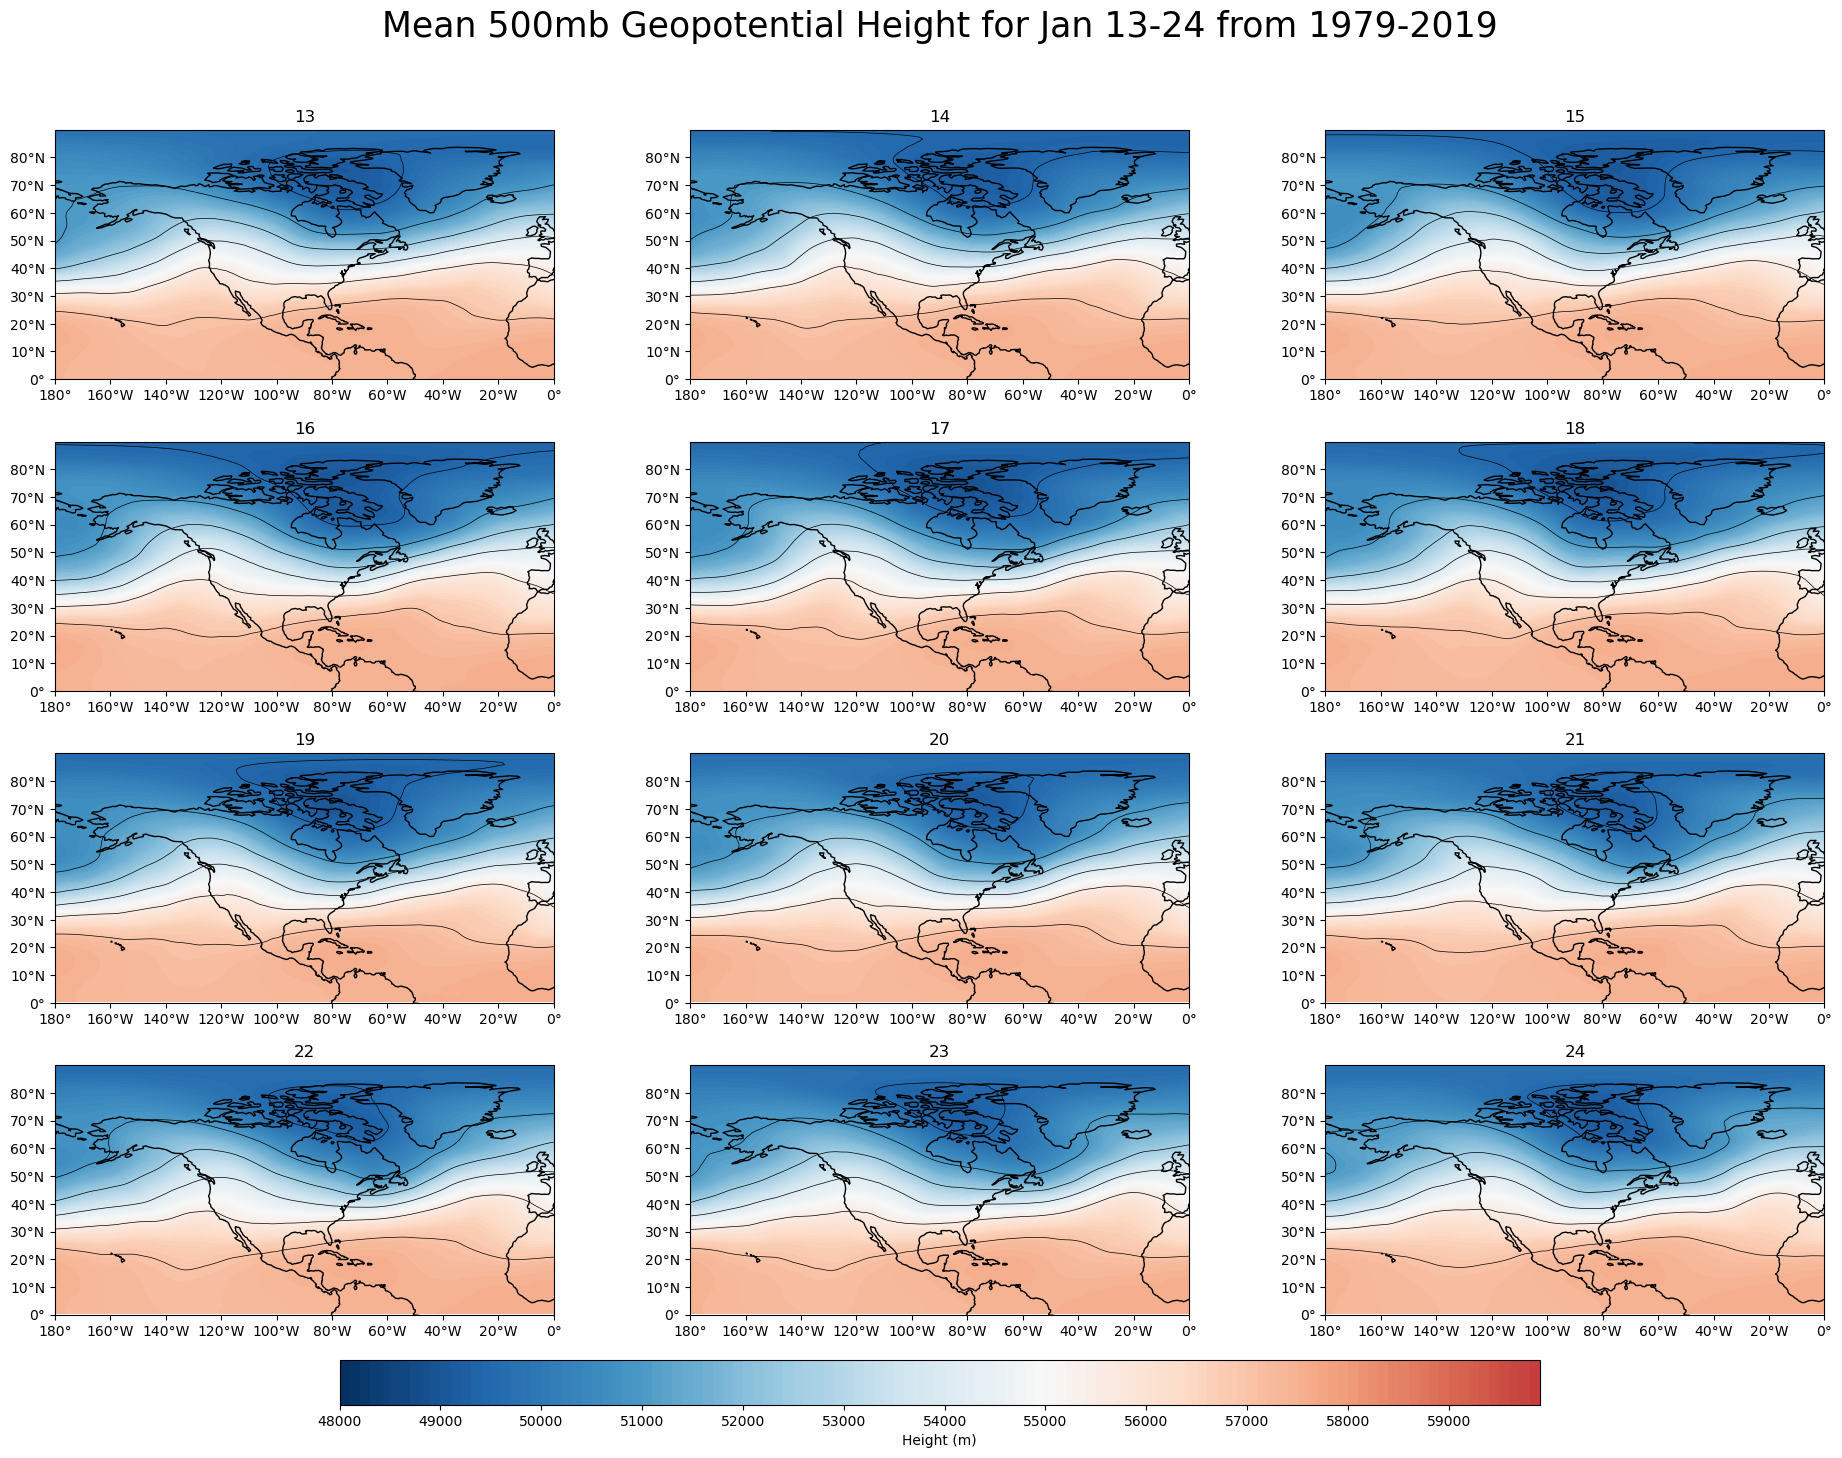

In [6]:


#Now to combine with a 'for' loop to create the plot            
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= ds_jan_dates['z500'].min()
max_z500= ds_jan_dates['z500'].max()
levels = np.arange(min_z500,max_z500,600)


#level range is smaller and step is finer and changed center of colorbar-----
#Changed the center since 500mb would range from 50000-60000 so 'technically' center would be 55000 m
#Also changed the colormap used- now rdbu_r


clevs = np.arange(48000,60000,100)
divnorm = mpl.colors.CenteredNorm(vcenter=55000)



axs=axs.flatten()

#Loop over all of the day and plot
for i, day in enumerate(ds_jan_dates['day']):

    # Select the day
    data=ds_jan_dates['z500'].sel(day=day)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,
                               coord=ds_jan_dates['lon'])

    # Contour plot
    cs=axs[i].contour(lons,
                      ds_jan_dates['lat'],
                      data,
                      transform = ccrs.PlateCarree(),
                      colors='black',
                      extend='both', 
                      linewidths= .5)
      
    #Color filled Contour Plot
    cs1=axs[i].contourf(lons, 
                ds_jan_dates['lat'],
                data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree())
    
 

    # Title each subplot with the name of the model
    axs[i].set_title(day.values)
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9,
                        left=0.05, 
                        right=0.95,
                        wspace=0.2, 
                        hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])

cbar=fig.colorbar(cs1, 
                  cax=cbar_ax,
                  orientation='horizontal',
                  label='Height (m)', ticks=np.linspace(48000, 60000, 13))



plt.suptitle('Mean 500mb Geopotential Height for Jan 13-24 from 1979-2019', 
             fontsize=25 )